In [110]:
import pandas as pd
import numpy as np
import pickle
from pyvi import ViTokenizer
from pyvi import ViUtils
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [144]:
data = pd.read_csv('tiki-review.csv')
data.head()

,label,text
0,5,Có vẻ ổn. Không giống như quá bền. Sẽ hv sử dụ...
1,5,"Đã thử, dòng điện có thể rất mạnh tùy thuộc và..."
2,5,Mặt hàng nhận được sau một tuần. Trông nhỏ hơn...
3,5,Cảm ơn!!! Hoạt động như mô tả không có khiếu n...
4,5,Giao hàng nhanh vì nó đến từ nước ngoài và chỉ...


In [146]:
# Chuyển về string
def to_string(text):
  return str(text)
data['text'] = data['text'].apply(to_string) 

In [148]:
# Loại bỏ ký tự đặc biệt 
import re

def remove_non_latin_characters(text):
  if isinstance(text, str): 
    pattern = r"[^\w\s]"
    return re.sub(pattern, "", text)
  else:
    return text

data["text"] = data["text"].apply(remove_non_latin_characters)


In [150]:
# Viết thường
data["text"] = data["text"].str.lower()

In [152]:
# Gán lại nhãn
def convert_labels(label):
  if label == 5:
    return 2
  elif label in [3, 4]:
    return 1
  elif label in [1, 2]:
    return 0
  else:
    return label

data['label'] = data['label'].apply(convert_labels)
data['label'].value_counts()

label
0    82686
1    45428
2    41132
Name: count, dtype: int64

In [158]:
data['length'] = data['text'].apply(len)

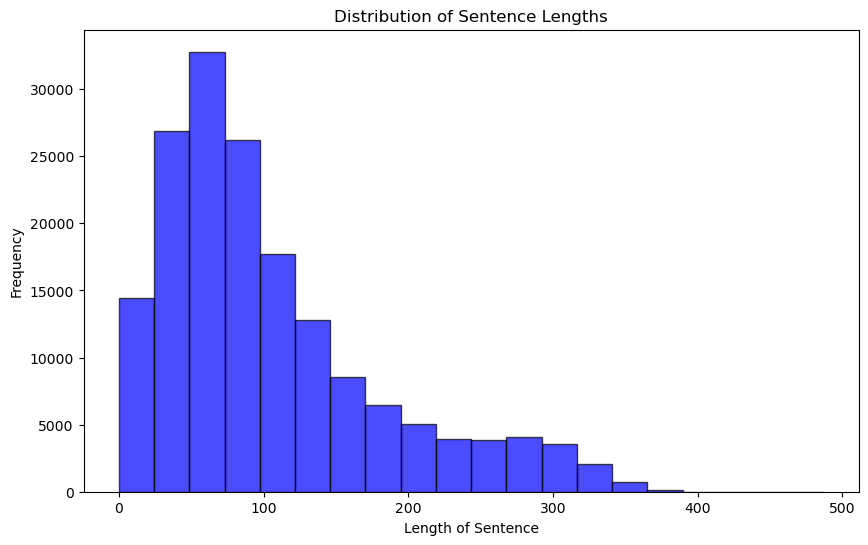

In [160]:
import matplotlib.pyplot as plt

# Plot the lengths
plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length of Sentence')
plt.ylabel('Frequency')
plt.show()

In [162]:
from sklearn.model_selection import train_test_split

X = data["text"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (135396,) (135396,)
Test data shape: (33850,) (33850,)


In [164]:
X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [166]:
def tokenize(text):
    return ViTokenizer.tokenize(text)

In [168]:
input_train = list(map(tokenize, X_train))
input_test = list(map(tokenize, X_test))  

In [169]:
tokenize_train = Tokenizer(oov_token='<OOV>', filters='', split=' ')
tokenize_train.fit_on_texts(input_train)
tokenize_test = Tokenizer(oov_token='<OOV>', filters='', split=' ')
tokenize_test.fit_on_texts(input_test)

In [170]:
tokenize_train_text = tokenize_train.texts_to_sequences(input_train)
tokenize_test_text = tokenize_test.texts_to_sequences(input_test)

In [171]:
data_train = pad_sequences(tokenize_train_text, padding='post', maxlen= 128)
data_test = pad_sequences(tokenize_test_text, padding='post', maxlen= 128)

In [172]:
pickle.dump(tokenize_train, open("tokenizer_data.pkl", "wb"))

In [173]:
print("Vocab: ", len(tokenize_train.word_index) + 1)

Vocab:  21122


In [174]:
print("Train lenght: ", len(data_train))
print("Test lenght: ", len(data_test))

Train lenght:  135396
Test lenght:  33850


In [175]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = 21122
    output_dim = 32
    input_length = 128
    initializer = tf.keras.initializers.GlorotNormal()
    
    input_layer = Input(shape=(input_length,))
    
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=initializer)(input_layer)
                        
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D(pool_size=2)(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D(pool_size=2)(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(cnn_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    
    bi_gru_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(cnn_feature)
    bi_gru_feature = LayerNormalization()(bi_gru_feature)
    
    combined_feature = Concatenate()([bi_lstm_feature, bi_gru_feature])
    combined_feature = GlobalMaxPooling1D()(combined_feature)
    combined_feature = LayerNormalization()(combined_feature)
    
    classifier = Dense(90, activation='relu')(combined_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)
    
    model = Model(inputs=input_layer, outputs=classifier)
    return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 128, 32)   │    675,904 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      3,104 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 64, 32)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64, 32)    │          0 │ max_pooling1d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 64, 32)    │      3,104 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 32, 32)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 32)    │         64 │ max_pooling1d_9[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 32, 32)    │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 32, 64)    │     16,640 │ dropout_25[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 32, 64)    │     12,672 │ dropout_25[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ bidirectional_8[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ bidirectional_9[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 128)   │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ concatenate_4[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 90)        │     11,610 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 90)        │          0 │ dense_20[0][0]  

 Total params: 735,153 (2.80 MB)

 Trainable params: 735,153 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Plot model
# img_file = "model_visualize.png"
# tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True)

In [178]:
# Define the ModelCheckpoint callback
callback = tf.keras.callbacks.ModelCheckpoint(
    'tiki-model.keras', 
    monitor='val_accuracy',
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save the whole model (architecture + weights)
    mode='max',  # Mode for monitoring ('auto', 'min', 'max')
)

# Train the model with the callback
history = model.fit(
    x=data_train, 
    y=y_train, 
    validation_data=(data_test, y_test), 
    epochs=50, 
    batch_size=32, 
    callbacks=[callback]
)


Epoch 1/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 132s 31ms/step - accuracy: 0.6642 - loss: 0.7619 - val_accuracy: 0.5124 - val_loss: 1.1660
Epoch 2/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 133s 32ms/step - accuracy: 0.7452 - loss: 0.6068 - val_accuracy: 0.5180 - val_loss: 1.2334
Epoch 3/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 130s 31ms/step - accuracy: 0.7611 - loss: 0.5728 - val_accuracy: 0.5043 - val_loss: 1.2935
Epoch 4/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 128s 30ms/step - accuracy: 0.7747 - loss: 0.5512 - val_accuracy: 0.5158 - val_loss: 1.1820
Epoch 5/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 130s 31ms/step - accuracy: 0.7830 - loss: 0.5325 - val_accuracy: 0.5159 - val_loss: 1.2624
Epoch 6/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 128s 30ms/step - accuracy: 0.7927 - loss: 0.5128 - val_accuracy: 0.5097 - val_loss: 1.2765
Epoch 7/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 133s 31ms/step - accuracy: 0.7962 - loss: 0.5042 - val_accuracy: 0.5147 - val_loss: 1.4359
Epoch 8/50
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 127s 30ms/step - accuracy: 

In [179]:
# load model
model = load_model('tiki-model.keras')

In [180]:
# Kiểm tra kết quả trên tập test
model.evaluate(data_test, y_test)

1058/1058 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5194 - loss: 1.3699


[1.3774118423461914, 0.5183751583099365]

In [218]:
def preprocessing_input(text, tokenizer, max_length=128):
    # Tokenize the input text
    text = text.lower()
    tokenized_text = ViTokenizer.tokenize(text)
    sequences = tokenizer.texts_to_sequences([tokenized_text])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

In [204]:
texts = ["Áo này bình thường, không có gì nổi bật", "Dùng rất tốt nhưng giao hàng chậm, bị móp ở vỏ, vẻ ngoài rất tệ", "Nhìn cũng ổn"]
with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

for text in texts:
    inp_text = preprocessing_input(text, my_tokenizer)
    result = model(inp_text).numpy()[0].argmax()
    print(result)

0
0
1


In [232]:
texts = ["không tốt",
         "Bình thường",
         "Nhìn cũng ổn"]

# Predict and calculate percentages
results = []
for text in texts:
    inp_text = preprocessing_input(text, my_tokenizer)
    result = model.predict(inp_text)[0]
    percentages = (result / np.sum(result)) * 100  # Calculate percentages
    results.append(percentages)

# Display results
for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Tốt: {results[i][2]:.2f}%, Bình thường: {results[i][1]:.2f}%, Tệ: {results[i][0]:.2f}%")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Text: không tốt
Tốt: 0.69%, Bình thường: 8.20%, Tệ: 91.12%

Text: Bình thường
Tốt: 10.43%, Bình thường: 66.39%, Tệ: 23.18%

Text: Nhìn cũng ổn
Tốt: 25.53%, Bình thường: 66.44%, Tệ: 8.03%



In [ ]:
# Giải thích:
'''
5 sao = 2
3-4 sao = 1
1-2 sao = 0
'''